In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# установка стиля matplotlib
%matplotlib inline
plt.style.use('ggplot')

# библиотека для расчетов корреляций
from scipy import stats
from sklearn import metrics

# библиотека модели линейной регрессии
from sklearn import linear_model

# библиотека модели деревьев решения
from sklearn import tree

# библиотека модели ансамблей
from sklearn import ensemble

# библиотека для разделения датасета
from sklearn import model_selection

# для обработки timestamp в формате utc
import datetime, time

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# логгирование / логирование
import logging

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# библиотека для передачи функции обратного вызова
from functools import partial

# библиотека поиска гиперпараметров hyperopt
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

# библиотека поиска гиперпараметров optuna
import optuna
from optuna import Trial, study, samplers

In [2]:
## КОНСТАНТЫ
# делитель для констант (для более быстрых расчётов)
DIVIDER = 2

# фиксация генерации воспроизведения 
RANDOM_SEED = 42

# число фолдов кросс-валидации
CV_FOLDS = 5

# число ядер для расчётов моделей
CPU = -1

# число итераций RandomizedSearchCV
N_ITER = int(50 / DIVIDER)

# число итераций Hyperopt
MAX_EVALS = int(50 / DIVIDER)

# число итераций Optuna
N_TRIALS = int(50 / DIVIDER)

In [3]:
# создаём объект класса LogisticRegression как estimator
def get_estimator_log_reg(**params:dict | None) -> linear_model.LogisticRegression:
    """ Функция генерации объекта класса: логистической регрессии (объекта класса LogisticRegression).
        Принимает на вход словарь с параметрами. Если словарь пустой - создаётся модель с параметрами по умолчанию.

    Args:
        params (dict | None):   внешний словарь параметров модели | значение None (пустой словарь). 
                                При значении None генерируется стандартный объект класса + заданные параметры в estimator_log_reg

    Returns:
        estimator_log_reg(linear_model.LogisticRegression): объект класса логистическая регрессия (LogisticRegression)
    """
    estimator_log_reg = linear_model.LogisticRegression(
        **params,
        random_state=RANDOM_SEED,
        n_jobs=CPU
    )
    return estimator_log_reg

# создаём объект класса RandomForestClassifier как estimator
def get_estimator_rf_clf(**params:dict | None) -> ensemble.RandomForestClassifier:
    """ Функция генерации объекта класса: "случайного леса" (объекта класса RandomForestClassifier).
        Принимает на вход словарь с параметрами. Если словарь пустой - создаётся модель с параметрами по умолчанию.

    Args:
        params (dict | None):   внешний словарь параметров модели | значение None (пустой словарь). 
                                При значении None генерируется стандартный объект класса + заданные параметры в estimator_rf_clf
        
    Returns:
        estimator_rf_clf(ensemble.RandomForestClassifier): объект класса "случайный лес" (RandomForestClassifier)
    """
    estimator_rf_clf = ensemble.RandomForestClassifier(
        **params,
        class_weight='balanced',        # веса классов
        random_state=RANDOM_SEED,
        n_jobs=CPU
    )
    return estimator_rf_clf

# 1. Загрузка данных, знакомство с данными, оценка данных

In [2]:
data = pd.read_csv('data/_train_sem09.csv')

# знакомимся с данными
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# проверяем пропуски, на всякий случай
data[data.isnull().any(axis=1)]

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776


Activity
1    0.542255
0    0.457745
Name: proportion, dtype: float64


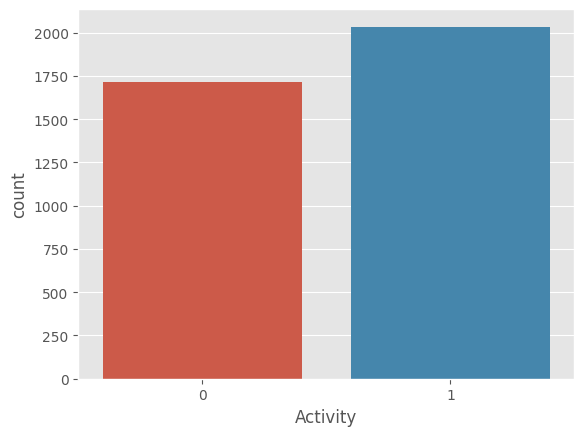

In [6]:
# сбалансированность классов
print(data['Activity'].value_counts(normalize=True))
sns.countplot(data=data, x='Activity');

---

# 2. Решение задачи

* Набор данных относительно сбалансированный. Разделим данные в соотношении 80/20 на тренировочную и тестовую выборки соответственно, используя стратификацию.

* Тестовую выборку мы будем использовать для оценки качества обученной модели. При настройке гиперпараметров модель видеть тестовые данные не будет.

* Будем использовать кросс-валидацию на каждом этапе, соответственно, выделять из обучающего набора данных валидационную выборку не нужно - алгоритм это сделает самостоятельно.

---

# 3. Разбиение данных

In [7]:
# матрица наблюдений
X = data.drop(['Activity'], axis=1)

# вектор ответов
y = data['Activity']

# разделяем выборку на тренировочную и тестовую в соотношении 80/20,
# используем параметр stratify (стратифицированное разбиение)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=RANDOM_SEED, 
    test_size=0.2
)

In [8]:
def get_model_metrics(
    estimator_:linear_model.LogisticRegression | ensemble.RandomForestClassifier, 
    opt_method:str=None, 
    cv_:int | None=CV_FOLDS, 
    X_train_:pd.DataFrame=X_train, y_train_:pd.Series=y_train, 
    X_test_:pd.DataFrame=X_test, y_test_:pd.Series=y_test,
    ) -> None:
    """ Функция вывода метрик.

    Parameters
    ----------
        estimator_ (linear_model.LogisticRegression | ensemble.RandomForestClassifier) : модель для расчёта метрик на кросс-валидации
            
        opt_method (str) : метод оптимизации. Defaults to None.

        cv_ (int, optional) : кросс-валидатор модели. Defaults to CV_FOLDS.
        
        X_train_ (pd.DataFrame, optional) : тренировочный датасет. Defaults to X_train.
        
        y_train_ (pd.Series, optional) : тренировочный вектор целевых значений. Defaults to y_train.
        
        X_test_ (pd.DataFrame, optional) : тестовый датасет. Defaults to X_test.
        
        y_test_ (pd.Series, optional) : тестовый вектор целевых значений. Defaults to y_test.
    """

    cv_metrics = model_selection.cross_validate(
            estimator=estimator_,           # модель
            X=X_train_,                     # матрица наблюдений X
            y=y_train_,                     # вектор ответов y
            cv=cv_,                         # число фолдов кросс-валидатора StratifiedKFold
            scoring=['f1', 'accuracy',
                'recall', 'precision'],     # метрики
            return_train_score=True,        # подсчёт метрики на тренировочных фолдах
            n_jobs=CPU
        )

    # обучение модели и предсказание значений для тестовой выборки
    estimator_.fit(X_train_, y_train_)
    y_pred_test_estimator_ = estimator_.predict(X_test_)
    
    # заголовок отчёта
    if opt_method:
        print(f'-= {estimator_.__class__.__name__}, {opt_method} =-')
    else:
        print(f'-= {estimator_.__class__.__name__}, Baseline =-')
    
    # выводим метрику на тестовой выборке
    print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test_, y_pred_test_estimator_):.3f}\n')
        
    # выводим метрики на кросс-валидации
    print(f"f1_score на тренировочном наборе: {np.mean(cv_metrics['train_f1']):.3f}")
    print(f"accuracy на валидационном наборе: {np.mean(cv_metrics['test_accuracy']):.3f}")
    print(f"f1_score на валидационном наборе: {np.mean(cv_metrics['test_f1']):.3f}")

---

# 4. Логистическая регрессия (LogisticRegression)

## 4.1. Baseline

Оцениваем метрику f1-score при установленных по умолчанию гиперпараметров:

In [9]:
# выводим метрики baseline решения (без оптимизации)
get_model_metrics(get_estimator_log_reg())

-= LogisticRegression, Baseline =-
f1_score на тестовом наборе: 0.780

f1_score на тренировочном наборе: 0.905
accuracy на валидационном наборе: 0.749
f1_score на валидационном наборе: 0.773


## 4.2. GridSearchCV

Алгоритм оптимизации зависит от выбранного типа штрафа:
* `'lbfgs' - ['l2', 'none']`
* '`sag' - ['l2', 'none']`
* `'liblinear' - ['l1', 'l2']`
* `'saga' - [elasticnet', 'l1', 'l2', 'none']`

In [60]:
# создаем сетку параметров
log_reg_C_values = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
l1_ratio = np.linspace(0, 1, num=10)
param_grid_log_reg = [
    {'penalty': ['l2', 'none'],     # тип регуляризации
    'solver': ['lbfgs', 'sag'],     # алгоритм оптимизации
    'C': log_reg_C_values           # уровень силы регуляризации
    },
            
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear'],
    'C': log_reg_C_values
    },
            
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'] ,
    'solver': ['saga'],
    'C': log_reg_C_values,
    # 'l1_ratio': stats.uniform(0, 1)
    'l1_ratio': l1_ratio
    }
]

In [58]:
# создаем объект класса GridSearchCV
gscv_log_reg = model_selection.GridSearchCV(
    estimator=get_estimator_log_reg(), 
    param_grid=param_grid_log_reg, 
    cv=CV_FOLDS, 
    n_jobs=CPU,
)

# обучаем модель на кросс-валидации
%time gscv_log_reg.fit(X_train, y_train)

print(f'Наилучшие значения гиперпараметров: {gscv_log_reg.best_params_}')

CPU times: total: 11.9 s
Wall time: 20min 42s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'penalty': ['l2', 'none'],
                          'solver': ['lbfgs', 'sag']},
                         {'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                          'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['saga']}])

Наилучшие значения гиперпараметров: {'C': 0.05, 'l1_ratio': 0.1111111111111111, 'penalty': 'elasticnet', 'solver': 'saga'}


In [59]:
# рассчитываем и выводим метрики
get_model_metrics(
    get_estimator_log_reg(**gscv_log_reg.best_params_),
    gscv_log_reg.__class__.__name__
)
print(f'Наилучшие значения гиперпараметров: {gscv_log_reg.best_params_}')

-= LogisticRegression, GridSearchCV =-
f1_score на тестовом наборе: 0.781

f1_score на тренировочном наборе: 0.831
accuracy на валидационном наборе: 0.770
f1_score на валидационном наборе: 0.795
Наилучшие значения гиперпараметров: {'C': 0.05, 'l1_ratio': 0.1111111111111111, 'penalty': 'elasticnet', 'solver': 'saga'}


## 4.3. RandomizedSearchCV

In [62]:
# создаем объект класса RandomizedSearch
rscv_log_reg = model_selection.RandomizedSearchCV(
    estimator=get_estimator_log_reg(), 
    param_distributions=param_grid_log_reg,
    cv=CV_FOLDS, 
    n_jobs=CPU,
    n_iter=N_ITER 
)

# обучаем модель на кросс-валидации
%time rscv_log_reg.fit(X_train, y_train) 

print(f'Наилучшие значения гиперпараметров: {rscv_log_reg.best_params_}')

CPU times: total: 6.33 s
Wall time: 1min 33s


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(n_jobs=-1, random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions=[{'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7,
                                               0.9, 1],
                                         'penalty': ['l2', 'none'],
                                         'solver': ['lbfgs', 'sag']},
                                        {'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7,
                                               0.9, 1],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear']},
                                        {'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7,
                                               0.9, 1],
                                         'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['saga']}])

Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.6666666666666666, 'C': 0.3}


In [63]:
# рассчитываем и выводим метрики
get_model_metrics(
    get_estimator_log_reg(**rscv_log_reg.best_params_),
    rscv_log_reg.__class__.__name__
)
print(f'Наилучшие значения гиперпараметров: {rscv_log_reg.best_params_}')

-= LogisticRegression, RandomizedSearchCV =-
f1_score на тестовом наборе: 0.782

f1_score на тренировочном наборе: 0.838
accuracy на валидационном наборе: 0.767
f1_score на валидационном наборе: 0.791
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.6666666666666666, 'C': 0.3}


## 4.4. Hyperopt

In [15]:
# зададим пространство поиска гиперпараметров, 3 набора, 
# т.к. для каждого типа регуляции подходят только определённые комбинации оптимизации
hyperopt_space_log_reg_1 = {
    'penalty': hp.choice('penalty', ['l2', 'none']),    # тип регуляризации
    'solver': hp.choice('solver', ['lbfgs', 'sag']),    # алгоритм оптимизации
    'C': hp.choice('C', log_reg_C_values)               # уровень силы регуляризации
}

#--------------------------------------------------------------------------------
hyperopt_space_log_reg_2 = {
    'penalty': hp.choice('penalty', ['l1', 'l2']), 
    'solver': hp.choice('solver', ['liblinear']), 
    'C': hp.choice('C', log_reg_C_values)
}

#--------------------------------------------------------------------------------
hyperopt_space_log_reg_3 = {
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']), 
    'solver': hp.choice('solver', ['saga']),
    'C': hp.choice('C', log_reg_C_values),
    # 0 <= l1_ratio <= 1, обязателен, если penalty='elasticnet'
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

In [16]:
def hyperopt_log_reg(
        space_params:dict, 
        X_train_:pd.DataFrame=X_train, y_train_:pd.Series=y_train, 
        cv_:int=CV_FOLDS, 
    ) -> float | np.ndarray:
    """ Функция поиска оптимальных гиперпараметров с помощью Hyperopt

    Args:
        space_params (dict): словарь-"пространство" гиперпараметров
        X_train_ (pd.DataFrame, optional): тренировочный датасет. Defaults to X_train.
        y_train_ (pd.Series, optional): тренировочный вектор целевых значений. Defaults to y_train.
        cv_ (int, optional): числов фолдов на кросс-валидации. Defaults to 5.

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """

    # повторяющиеся параметры пространства
    params = {
        'penalty': space_params['penalty'], 
        'solver': space_params['solver'], 
        'C': space_params['C'],
    }

    # создаём модель обучения с заданными параметрами
    try:
        model_hyperopt_log_reg_ = get_estimator_log_reg(
            **params,
            l1_ratio=space_params['l1_ratio'],
        )
        
    except KeyError:
        model_hyperopt_log_reg_ = get_estimator_log_reg(
            **params,
        )

    # обучаем модель на кросс-валидации
    score = model_selection.cross_val_score(
        model_hyperopt_log_reg_, 
        X_train_, y_train_, 
        cv=cv_, 
        scoring='f1', 
        n_jobs=CPU
        ).mean()
    
    # метрику необходимо минимизировать, поэтому ставим знак минус,
    # возвращая инвертированное значение
    return -score

In [17]:
%%time
## расчёты для hyperopt_space_log_reg_1
trials_hyperopt_log_reg_1 = Trials()            # используется для логирования результатов

study_hyperopt_log_reg_1 = fmin(
    fn=partial(
        hyperopt_log_reg, 
        X_train_=X_train, y_train_=y_train,
        cv_=CV_FOLDS,
    ),                                          # наша функция
    space=hyperopt_space_log_reg_1,             # пространство гиперпараметров
    algo=tpe.suggest,                           # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=MAX_EVALS,                        # максимальное количество итераций
    trials=trials_hyperopt_log_reg_1,           # логирование результатов
    rstate=np.random.default_rng(RANDOM_SEED)   # фиксируем для повторяемости результата
)

print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_log_reg_1, study_hyperopt_log_reg_1)}')

100%|██████████| 25/25 [01:25<00:00,  3.41s/trial, best loss: -0.7907284724091234]
Наилучшие значения гиперпараметров 
{'C': 0.05, 'penalty': 'l2', 'solver': 'sag'}
CPU times: total: 1.05 s
Wall time: 1min 25s


In [18]:
%%time
## расчёты для hyperopt_space_log_reg_2
trials_hyperopt_log_reg_2 = Trials()            # используется для логирования результатов

study_hyperopt_log_reg_2 = fmin(
    fn=partial(
        hyperopt_log_reg, 
        X_train_=X_train, y_train_=y_train,
        cv_=CV_FOLDS,
    ),                                          # наша функция
    space=hyperopt_space_log_reg_2,             # пространство гиперпараметров
    algo=tpe.suggest,                           # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=MAX_EVALS,                        # максимальное количество итераций
    trials=trials_hyperopt_log_reg_2,           # логирование результатов
    rstate=np.random.default_rng(RANDOM_SEED)   # фиксируем для повторяемости результата
)

print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_log_reg_2, study_hyperopt_log_reg_2)}')

100%|██████████| 25/25 [00:21<00:00,  1.19trial/s, best loss: -0.7896620382423478]
Наилучшие значения гиперпараметров 
{'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: total: 1.06 s
Wall time: 21 s


In [19]:
%%time
## расчёты для hyperopt_space_log_reg_3
trials_hyperopt_log_reg_3 = Trials()            # используется для логирования результатов

study_hyperopt_log_reg_3 = fmin(
    fn=partial(
        hyperopt_log_reg, 
        X_train_=X_train, y_train_=y_train,
        cv_=CV_FOLDS,
    ),                                          # наша функция
    space=hyperopt_space_log_reg_3,             # пространство гиперпараметров
    algo=tpe.suggest,                           # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=MAX_EVALS,                        # максимальное количество итераций
    trials=trials_hyperopt_log_reg_3,           # логирование результатов
    rstate=np.random.default_rng(RANDOM_SEED)   # фиксируем для повторяемости результата
)

print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_log_reg_3, study_hyperopt_log_reg_3)}')

100%|██████████| 25/25 [02:20<00:00,  5.63s/trial, best loss: -0.7913324555968615]
Наилучшие значения гиперпараметров 
{'C': 0.3, 'l1_ratio': 0.7130445215144277, 'penalty': 'l1', 'solver': 'saga'}
CPU times: total: 1.09 s
Wall time: 2min 20s


### Построение метрик моделей по результатам оптимизации Hyperopt:

In [20]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_log_reg(**hyperopt.space_eval(hyperopt_space_log_reg_1, study_hyperopt_log_reg_1)), 
    str(trials_hyperopt_log_reg_1).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_log_reg_1, study_hyperopt_log_reg_1)}')

-= LogisticRegression, Hyperopt =-
f1_score на тестовом наборе: 0.788

f1_score на тренировочном наборе: 0.850
accuracy на валидационном наборе: 0.766
f1_score на валидационном наборе: 0.791
Наилучшие значения гиперпараметров 
{'C': 0.05, 'penalty': 'l2', 'solver': 'sag'}


In [21]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_log_reg(**hyperopt.space_eval(hyperopt_space_log_reg_2, study_hyperopt_log_reg_2)), 
    str(trials_hyperopt_log_reg_2).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_log_reg_2, study_hyperopt_log_reg_2)}')

-= LogisticRegression, Hyperopt =-
f1_score на тестовом наборе: 0.783

f1_score на тренировочном наборе: 0.850
accuracy на валидационном наборе: 0.765
f1_score на валидационном наборе: 0.790
Наилучшие значения гиперпараметров 
{'C': 0.05, 'penalty': 'l2', 'solver': 'liblinear'}


In [22]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_log_reg(**hyperopt.space_eval(hyperopt_space_log_reg_3, study_hyperopt_log_reg_3)), 
    str(trials_hyperopt_log_reg_3).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_log_reg_3, study_hyperopt_log_reg_3)}')

-= LogisticRegression, Hyperopt =-
f1_score на тестовом наборе: 0.782

f1_score на тренировочном наборе: 0.838
accuracy на валидационном наборе: 0.767
f1_score на валидационном наборе: 0.791
Наилучшие значения гиперпараметров 
{'C': 0.3, 'l1_ratio': 0.7130445215144277, 'penalty': 'l1', 'solver': 'saga'}


## 4.5. Optuna

In [23]:
def optuna_log_reg_1_2(trial) -> float | np.ndarray:
    """ Функция, обучающая модель LogisticRegression по переданным гиперпараметрам набора

    Args:
        trial: класс вызова гиперпараметров

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """

    # задаем пространство поиска гиперпараметров (1-ый и 2-ой набор значений)
    param_1_2 = {
        'penalty': Trial.suggest_categorical(trial, 'penalty', ['l1', 'l2', 'none']),
        'solver': Trial.suggest_categorical(trial, 'solver', ['lbfgs', 'sag', 'liblinear']),
        'C': Trial.suggest_categorical(trial, 'C', log_reg_C_values)
    }
    
    # обучаем модель на кросс-валидации
    score = model_selection.cross_val_score(
        get_estimator_log_reg(**param_1_2), 
        X_train, y_train, 
        cv=CV_FOLDS, 
        scoring='f1', 
        n_jobs=CPU
        ).mean()

    return score

# ------------------------------------------------------------------------------------------------
def optuna_log_reg_3(trial) -> float | np.ndarray:
    """ Функция, обучающая модель LogisticRegression по имеющимся гиперпараметрам набора

    Args:
        trial: класс вызова гиперпараметров

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """

    # задаем пространство поиска гиперпараметров (3-ий набор значений)
    param_3 = {
        'penalty': Trial.suggest_categorical(trial, 'penalty', ['l1', 'l2', 'elasticnet', 'none']),
        'solver': Trial.suggest_categorical(trial, 'solver', ['saga']),
        'C': Trial.suggest_categorical(trial, 'C', log_reg_C_values),
        'l1_ratio': Trial.suggest_float(trial, 'l1_ratio', 0.1, 1)
    }
    
    # обучаем модель на кросс-валидации
    score = model_selection.cross_val_score(
        get_estimator_log_reg(**param_3), 
        X_train, y_train, 
        cv=CV_FOLDS, 
        scoring='f1', 
        n_jobs=CPU
        ).mean()

    return score

In [49]:
%%time
# задаём сетку параметров 1-ого набора гиперпараметров
optuna_space_log_reg_1 = {
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'sag'],
    'C': log_reg_C_values,
}

# cоздаем объект исследования для 1-ого набора гиперпараметров
optuna_study_log_reg_1 = study.create_study(
    study_name='LogisticRegression', 
    direction='maximize', 
    sampler=samplers.GridSampler(optuna_space_log_reg_1)
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna_study_log_reg_1.optimize(optuna_log_reg_1_2, n_trials=N_TRIALS)

print(f'Наилучшие значения гиперпараметров {optuna_study_log_reg_1.best_params}')

[I 2023-05-01 16:47:31,451] A new study created in memory with name: LogisticRegression
[I 2023-05-01 16:47:33,497] Trial 0 finished with value: 0.7799538322682326 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.5}. Best is trial 0 with value: 0.7799538322682326.
[I 2023-05-01 16:47:35,445] Trial 1 finished with value: 0.7517432823840096 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.01}. Best is trial 0 with value: 0.7799538322682326.
[I 2023-05-01 16:47:40,171] Trial 2 finished with value: 0.7720227869170968 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.05}. Best is trial 0 with value: 0.7799538322682326.
[I 2023-05-01 16:47:44,990] Trial 3 finished with value: 0.7720227869170968 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.01}. Best is trial 0 with value: 0.7799538322682326.
[I 2023-05-01 16:47:49,842] Trial 4 finished with value: 0.7720227869170968 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.9}. Best is trial 0

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.05}
CPU times: total: 1.11 s
Wall time: 1min 24s


In [25]:
%%time
# задаём сетку параметров 2-ого набора гиперпараметров
optuna_space_log_reg_2 = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'C': log_reg_C_values,
}

# cоздаем объект исследования для 2-ого набора гиперпараметров
optuna_study_log_reg_2 = study.create_study(
    study_name='LogisticRegression', 
    direction='maximize', 
    sampler=samplers.GridSampler(optuna_space_log_reg_2)
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna_study_log_reg_2.optimize(optuna_log_reg_1_2, n_trials=N_TRIALS)

print(f'Наилучшие значения гиперпараметров {optuna_study_log_reg_2.best_params}')

[I 2023-05-01 16:25:04,166] A new study created in memory with name: LogisticRegression
[I 2023-05-01 16:25:04,902] Trial 0 finished with value: 0.7653885569492547 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.05}. Best is trial 0 with value: 0.7653885569492547.
[I 2023-05-01 16:25:05,580] Trial 1 finished with value: 0.7896620382423478 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.05}. Best is trial 1 with value: 0.7896620382423478.
[I 2023-05-01 16:25:06,450] Trial 2 finished with value: 0.7773822422375872 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.3}. Best is trial 1 with value: 0.7896620382423478.
[I 2023-05-01 16:25:06,940] Trial 3 finished with value: 0.7577274583182511 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.01}. Best is trial 1 with value: 0.7896620382423478.
[I 2023-05-01 16:25:08,128] Trial 4 finished with value: 0.7817081325696608 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.9

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.05}
CPU times: total: 641 ms
Wall time: 13.8 s


In [26]:
%%time
# cоздаем объект исследования для 3-его набора гиперпараметров
optuna_study_log_reg_3 = study.create_study(
    study_name='LogisticRegression', 
    direction='maximize'
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna_study_log_reg_3.optimize(optuna_log_reg_3, n_trials=N_TRIALS)

print(f'Наилучшие значения гиперпараметров {optuna_study_log_reg_3.best_params}')

[I 2023-05-01 16:25:17,999] A new study created in memory with name: LogisticRegression
[I 2023-05-01 16:25:23,520] Trial 0 finished with value: 0.7682421282574534 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.05, 'l1_ratio': 0.8121180276107328}. Best is trial 0 with value: 0.7682421282574534.
[I 2023-05-01 16:25:28,282] Trial 1 finished with value: 0.7784186232901155 and parameters: {'penalty': 'none', 'solver': 'saga', 'C': 0.01, 'l1_ratio': 0.17031418963849854}. Best is trial 1 with value: 0.7784186232901155.
[I 2023-05-01 16:25:32,940] Trial 2 finished with value: 0.778228428701617 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.5, 'l1_ratio': 0.779181610724005}. Best is trial 1 with value: 0.7784186232901155.
[I 2023-05-01 16:25:40,213] Trial 3 finished with value: 0.7787869892656051 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.9, 'l1_ratio': 0.46348177244487243}. Best is trial 3 with value: 0.7787869892656051.
[I 2023-05-01 16:25:41,650] Tria

Наилучшие значения гиперпараметров {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.3, 'l1_ratio': 0.9851778989869071}
CPU times: total: 1.09 s
Wall time: 2min 20s


### Построение метрик моделей по результатам оптимизации Optuna:

In [51]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_log_reg(**optuna_study_log_reg_1.best_params), 
    str(optuna_study_log_reg_1).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров {optuna_study_log_reg_1.best_params}')

-= LogisticRegression, Optuna =-
f1_score на тестовом наборе: 0.788

f1_score на тренировочном наборе: 0.850
accuracy на валидационном наборе: 0.766
f1_score на валидационном наборе: 0.791
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.05}


In [48]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_log_reg(**optuna_study_log_reg_2.best_params), 
    str(optuna_study_log_reg_2).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров {optuna_study_log_reg_2.best_params}')

-= LogisticRegression, Optuna =-
f1_score на тестовом наборе: 0.783

f1_score на тренировочном наборе: 0.850
accuracy на валидационном наборе: 0.765
f1_score на валидационном наборе: 0.790
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.05}


In [29]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_log_reg(**optuna_study_log_reg_3.best_params), 
    str(optuna_study_log_reg_3).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров {optuna_study_log_reg_3.best_params}')

-= LogisticRegression, Optuna =-
f1_score на тестовом наборе: 0.783

f1_score на тренировочном наборе: 0.838
accuracy на валидационном наборе: 0.767
f1_score на валидационном наборе: 0.791
Наилучшие значения гиперпараметров {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.3, 'l1_ratio': 0.9851778989869071}


In [30]:
# type: ignore
optuna.visualization.plot_optimization_history(optuna_study_log_reg_3, target_name='f1_score')

# 5. Случайный лес (RandomForestClassifier)

## 5.1. Baseline

Оцениваем метрику f1-score при установленных по умолчанию гиперпараметров:

In [31]:
# выводим метрики baseline решения (без оптимизации)
get_model_metrics(get_estimator_rf_clf())

-= RandomForestClassifier, Baseline =-
f1_score на тестовом наборе: 0.796

f1_score на тренировочном наборе: 1.000
accuracy на валидационном наборе: 0.796
f1_score на валидационном наборе: 0.815


## 5.2. GridSearchCV

In [32]:
# создаем сетку параметров
rf_clf_N_estimators_values = np.linspace(50, 200, 7, dtype=int)
rf_clf_max_depth_values = np.linspace(5, 30, 6, dtype=int)
param_grid_rf_cls = {
    'n_estimators': list(rf_clf_N_estimators_values),
    'max_depth': list(rf_clf_max_depth_values),
    'min_samples_leaf': [2, 3],
    'criterion': ['gini', 'entropy']
}

In [33]:
# создаем объект класса GridSearchCV
gscv_rf_clf = model_selection.GridSearchCV(
    estimator=get_estimator_rf_clf(), 
    param_grid=param_grid_rf_cls, 
    cv=CV_FOLDS, 
    n_jobs=CPU,
)

# обучаем модель на кросс-валидации
%time gscv_rf_clf.fit(X_train, y_train)

print(f'Наилучшие значения гиперпараметров: {gscv_rf_clf.best_params_}')

CPU times: total: 8.03 s
Wall time: 3min 9s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [2, 3],
                         'n_estimators': [50, 75, 100, 125, 150, 175, 200]})

Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 200}


In [34]:
# рассчитываем и выводим метрики
get_model_metrics(
    get_estimator_rf_clf(**gscv_rf_clf.best_params_), 
    gscv_rf_clf.__class__.__name__
)
print(f'Наилучшие значения гиперпараметров: {gscv_rf_clf.best_params_}')

-= RandomForestClassifier, GridSearchCV =-
f1_score на тестовом наборе: 0.809

f1_score на тренировочном наборе: 0.994
accuracy на валидационном наборе: 0.803
f1_score на валидационном наборе: 0.821
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 200}


## 5.3. RandomizedSearchCV

In [35]:
# создаем объект класса RandomizedSearch
rscv_rf_clf = model_selection.RandomizedSearchCV(
    estimator=get_estimator_rf_clf(), 
    param_distributions=param_grid_rf_cls,
    cv=CV_FOLDS, 
    n_jobs=CPU,
    n_iter=N_ITER 
)

# обучаем модель на кросс-валидации
%time rscv_rf_clf.fit(X_train, y_train) 

print(f'Наилучшие значения гиперпараметров: {rscv_rf_clf.best_params_}')

CPU times: total: 3.27 s
Wall time: 28.3 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_samples_leaf': [2, 3],
                                        'n_estimators': [50, 75, 100, 125, 150,
                                                         175, 200]})

Наилучшие значения гиперпараметров: {'n_estimators': 125, 'min_samples_leaf': 2, 'max_depth': 25, 'criterion': 'entropy'}


In [36]:
# рассчитываем и выводим метрики
get_model_metrics(
    get_estimator_rf_clf(**rscv_rf_clf.best_params_), 
    rscv_rf_clf.__class__.__name__
)
print(f'Наилучшие значения гиперпараметров: {rscv_rf_clf.best_params_}')

-= RandomForestClassifier, RandomizedSearchCV =-
f1_score на тестовом наборе: 0.803

f1_score на тренировочном наборе: 0.995
accuracy на валидационном наборе: 0.801
f1_score на валидационном наборе: 0.819
Наилучшие значения гиперпараметров: {'n_estimators': 125, 'min_samples_leaf': 2, 'max_depth': 25, 'criterion': 'entropy'}


## 5.4. Hyperopt

In [37]:
# пространство поиска гиперпараметров
hyperopt_space_rf_clf = {
    'n_estimators': hp.choice('n_estimators', rf_clf_N_estimators_values), 
    'max_depth': hp.choice('max_depth', rf_clf_max_depth_values),
    'min_samples_leaf': hp.choice('min_samples_leaf', [2, 3]),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

In [38]:
def hyperopt_rf_clf(
        space_params:dict, 
        X_train_:pd.DataFrame=X_train, y_train_:pd.Series=y_train, 
        cv_:int=CV_FOLDS, 
    ) -> float | np.ndarray:
    """ Функция поиска оптимальных гиперпараметров с помощью Hyperopt

    Args:
        space_params (dict): словарь-"пространство" гиперпараметров
        X_train_ (pd.DataFrame, optional): тренировочный датасет. Defaults to X_train.
        y_train_ (pd.Series, optional): тренировочный вектор целевых значений. Defaults to y_train.
        cv_ (int, optional): числов фолдов на кросс-валидации. Defaults to 5.

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """

    # повторяющиеся параметры пространства
    params = {
        'n_estimators': space_params['n_estimators'], 
        'max_depth': space_params['max_depth'],
        'min_samples_leaf': space_params['min_samples_leaf'],
        'criterion': space_params['criterion']
    }

    # обучаем модель на кросс-валидации
    score = model_selection.cross_val_score(
        get_estimator_rf_clf(**params), 
        X_train_, y_train_, 
        cv=cv_, 
        scoring='f1', 
        n_jobs=CPU
        ).mean()
    
    # метрику необходимо минимизировать, поэтому ставим знак минус,
    # возвращая инвертированное значение
    return -score

In [39]:
%%time
## расчёты для hyperopt_space_rf_clf
trials_hyperopt_rf_clf = Trials()               # используется для логирования результатов

study_hyperopt_rf_clf = fmin(
    fn=partial(
        hyperopt_rf_clf, 
        X_train_=X_train, y_train_=y_train,
        cv_=CV_FOLDS,
    ),                                          # наша функция
    space=hyperopt_space_rf_clf,                # пространство гиперпараметров
    algo=tpe.suggest,                           # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=MAX_EVALS,                        # максимальное количество итераций
    trials=trials_hyperopt_rf_clf,              # логирование результатов
    rstate=np.random.default_rng(RANDOM_SEED)   # фиксируем для повторяемости результата
)

print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_rf_clf, study_hyperopt_rf_clf)}')

100%|██████████| 25/25 [00:37<00:00,  1.51s/trial, best loss: -0.8188571186886069]
Наилучшие значения гиперпараметров 
{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 2, 'n_estimators': 125}
CPU times: total: 844 ms
Wall time: 37.8 s


In [40]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_rf_clf(**hyperopt.space_eval(hyperopt_space_rf_clf, study_hyperopt_rf_clf)), 
    str(trials_hyperopt_rf_clf).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров \n' \
    f'{hyperopt.space_eval(hyperopt_space_rf_clf, study_hyperopt_rf_clf)}')

-= RandomForestClassifier, Hyperopt =-
f1_score на тестовом наборе: 0.803

f1_score на тренировочном наборе: 0.995
accuracy на валидационном наборе: 0.801
f1_score на валидационном наборе: 0.819
Наилучшие значения гиперпараметров 
{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 2, 'n_estimators': 125}


## 5.5. Optuna

In [41]:
def optuna_rf_clf(trial) -> float | np.ndarray:
    """ Функция, обучающая модель RandomForestClassifier по имеющимся гиперпараметрам набора

    Args:
        trial: класс вызова гиперпараметров

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """

    # задаем пространство поиска гиперпараметров
    params_ = {
        'n_estimators': Trial.suggest_categorical(trial, 'n_estimators', rf_clf_N_estimators_values),
        'max_depth': Trial.suggest_categorical(trial, 'max_depth', rf_clf_max_depth_values),
        'min_samples_leaf': Trial.suggest_categorical(trial, 'min_samples_leaf', [2, 3]),
        'criterion': Trial.suggest_categorical(trial, 'criterion', ['gini', 'entropy'])
    }
    
    # обучаем модель на кросс-валидации
    score = model_selection.cross_val_score(
        get_estimator_rf_clf(**params_), 
        X_train, y_train, 
        cv=CV_FOLDS, 
        scoring='f1', 
        n_jobs=CPU
        ).mean()

    return score

In [42]:
%%time
# cоздаем объект исследования для набора гиперпараметров
optuna_study_rf_clf = study.create_study(
    study_name='RandomForestClassifier', 
    direction='maximize'
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna_study_rf_clf.optimize(optuna_rf_clf, n_trials=N_TRIALS)

print(f'Наилучшие значения гиперпараметров {optuna_study_rf_clf.best_params}')

[I 2023-05-01 16:32:23,645] A new study created in memory with name: RandomForestClassifier
[I 2023-05-01 16:32:25,036] Trial 0 finished with value: 0.8124347927591806 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8124347927591806.
[I 2023-05-01 16:32:26,096] Trial 1 finished with value: 0.751856445956867 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8124347927591806.
[I 2023-05-01 16:32:27,585] Trial 2 finished with value: 0.8110836198212501 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8124347927591806.
[I 2023-05-01 16:32:29,257] Trial 3 finished with value: 0.8154940155407129 and parameters: {'n_estimators': 125, 'max_depth': 25, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 3 with value: 0.8154940155407129.
[I 20

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 2, 'criterion': 'entropy'}
CPU times: total: 812 ms
Wall time: 44.7 s


In [43]:
# рассчитываем и выводим метрики
# type: ignore
get_model_metrics(
    get_estimator_rf_clf(**optuna_study_rf_clf.best_params), 
    str(optuna_study_rf_clf).split('.')[0].split('<')[1].capitalize()
)
print(f'Наилучшие значения гиперпараметров {optuna_study_rf_clf.best_params}')

-= RandomForestClassifier, Optuna =-
f1_score на тестовом наборе: 0.809

f1_score на тренировочном наборе: 0.994
accuracy на валидационном наборе: 0.803
f1_score на валидационном наборе: 0.821
Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 2, 'criterion': 'entropy'}


In [44]:
# type: ignore
optuna.visualization.plot_optimization_history(optuna_study_rf_clf, target_name='f1_score')

# 6. Выводы

Исходя из поставленной задачи были обучены две модели с параметрами, установленным по умолчанию (Baseline):
* логистической регрессии;
* модель случайного леса.

Далее были подобраны гиперпараметры каждой из моделей 4 способами и каждая из моделей обучена на кросс-валидации:
* *GridSeachCV*,
* *RandomizedSearchCV*,
* *Hyperopt*,
* *Optuna*. 


**Общие выводы:**

* Все методы позволили существенно улучшить метрику базовых моделей;

* В модели **RandomForestClassifier** настройки по умолчанию подобраны оптимальным образом, поэтому каждый метод поиска оптимальных гиперпараметров показал незначительное улучшение метрики f1-score. 

* Самый ресурснозатратный способ - сочетание модели **LogisticRegression** и *GridSeachCV*;

* Самые лучшие метрики - сочетание модели **RandomForestClassifier** и *Optuna*;

* Самые лучшие метрики и самый быстрый способ нахождения оптимальных гиперпараметров для **LogisticRegression** - *Optuna*;

* Самые лучшие метрики и самый быстрый способ нахождения оптимальных гиперпараметров для моделей, поставленных в задаче - сочетание модели **RandomForestClassifier** и *RandomizedSearchCV*.